# Readme

Set firstInstallation=True, when running model training before main.py has been executed in initial installation mode to set up environment

In [1]:
firstInstallation=False

# 1. System setup

## 1.1 Define parameters

In [2]:
# Define pretrained model to be downloaded
pre_trained_model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'
pre_trained_model_name = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
img_size = (640, 640)

## 1.2 Create folder structure and install required modules

In [3]:
# Import basic packages
import os
import shutil
import platform
import subprocess

# Initialise usage of colab
import setup
import userSettings
userSettings = userSettings.main()

files, paths = setup.installPackages(userSettings['homePath'], userSettings['labels'], firstInstallation)

os.chdir(paths['home'])    

# Import installed packages
from matplotlib import pyplot as plt
%matplotlib inline
import cv2 as cv
import uuid
import time
import pathlib
import shutil
import math
import wget
import sys
import numpy as np
from xml.etree.ElementTree import ElementTree
from xml.etree.ElementTree import Element
import xml.etree.ElementTree as etree
import xml.dom.minidom
from lxml import etree

import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

.
Checking system setup
.
Successfully created /Volumes/Niklas/macOS/BachelorNB/projectTeleoperatedTaxibot/2_ObjectDetection/2_Tensorflow/workspace/training/images/training from scratch.
Successfully created /Volumes/Niklas/macOS/BachelorNB/projectTeleoperatedTaxibot/2_ObjectDetection/2_Tensorflow/workspace/training/images/testing from scratch.
.
System setup completed...
.


## 4.2 Partition images for testing and training

**Important**: Images of objects must be in the following format: "SameClass_1.png", "SameClass_3.png" and must be located in their respective folders in 0User_Input/objects. The same is true for backgrounds

In [4]:
# Create dict with labels
labels = userSettings['labels']
dict_labels = {}
num = 1
for label in labels:    
    dict_labels[label]= num
    num += 1
print(dict_labels)

{'Engine': 1}


Found 5 backgrounds
Found 4 objects for label: Engine. Multiplying by factor 5
Multiplying image: Engine_4.png
Multiplying image: Engine_1.png
Multiplying image: Engine_2.png
Multiplying image: Engine_3.png
Multiplication completed. Currently available for label: Engine, total: 20, testing: 4, training: 16


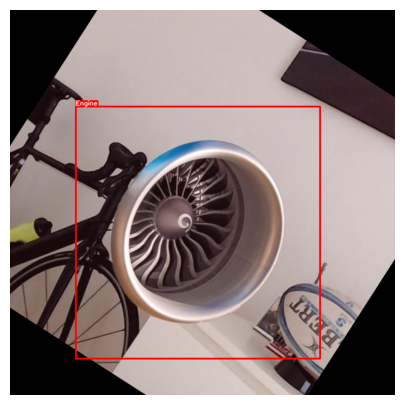

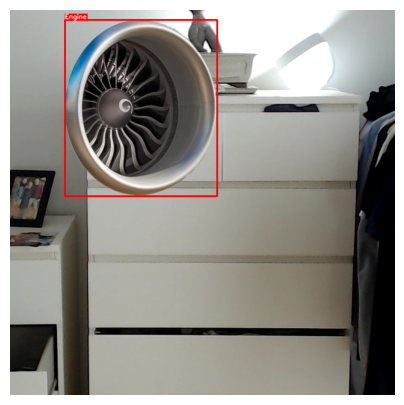

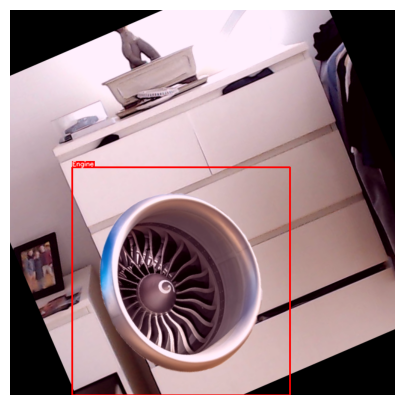

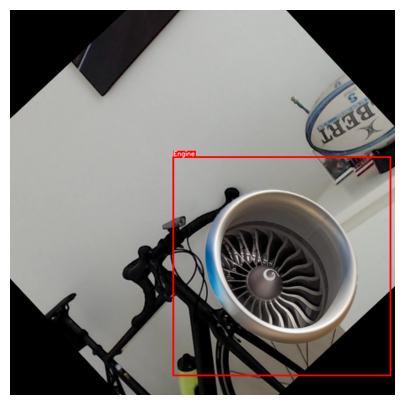

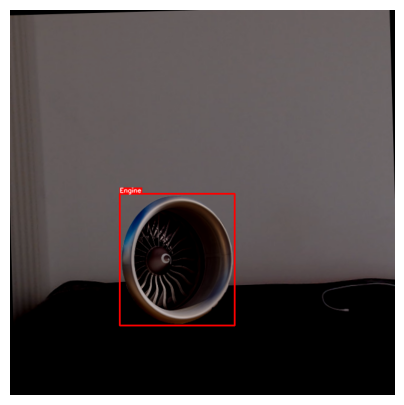

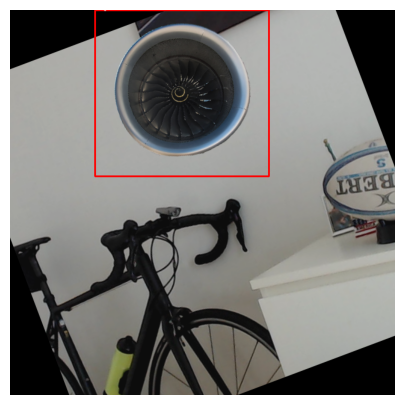

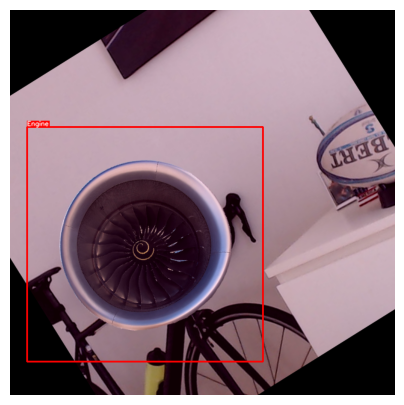

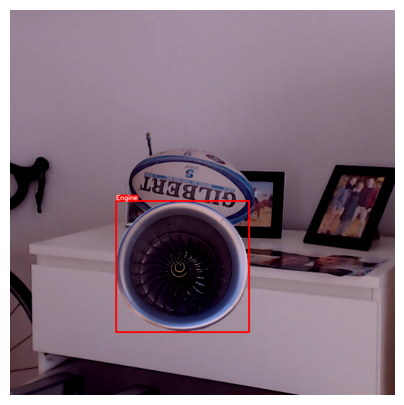

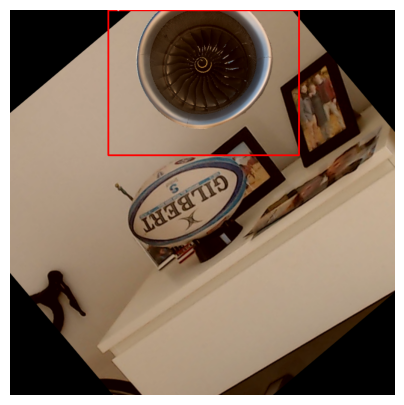

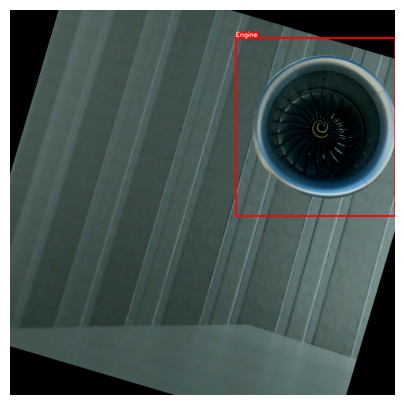

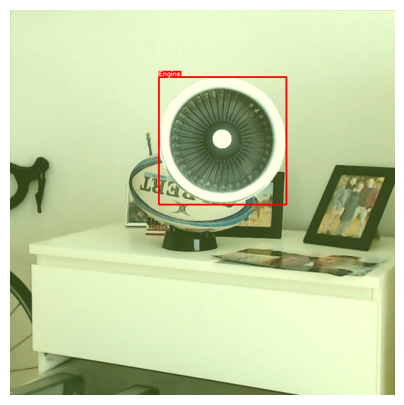

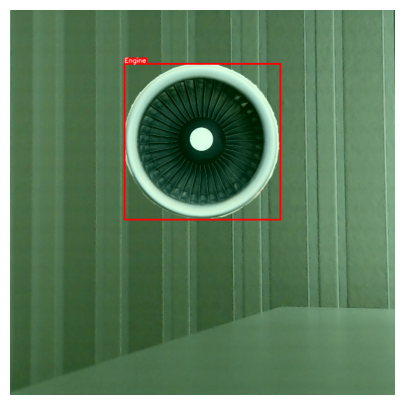

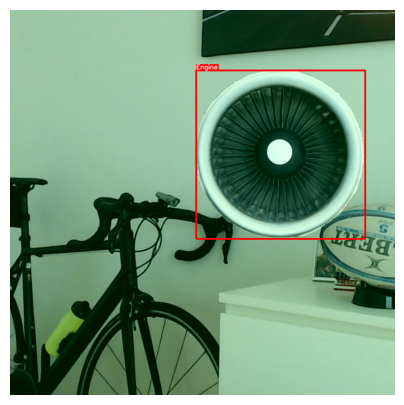

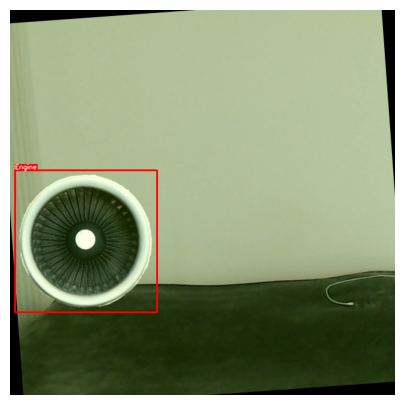

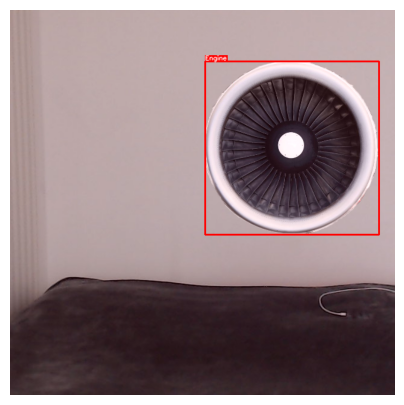

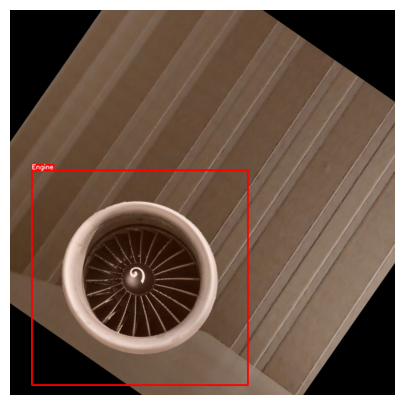

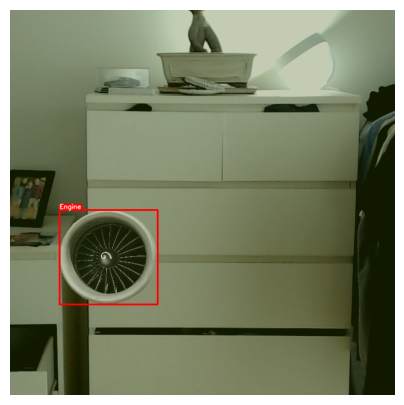

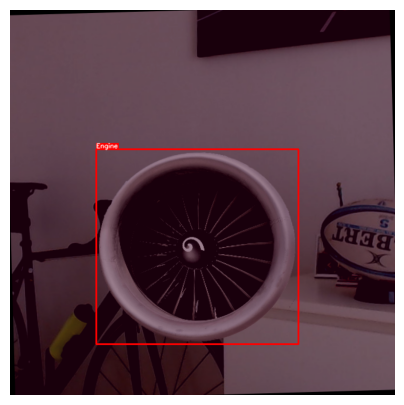

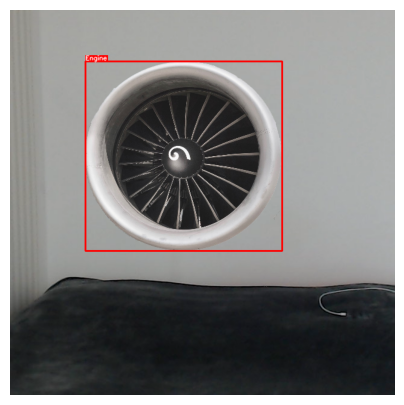

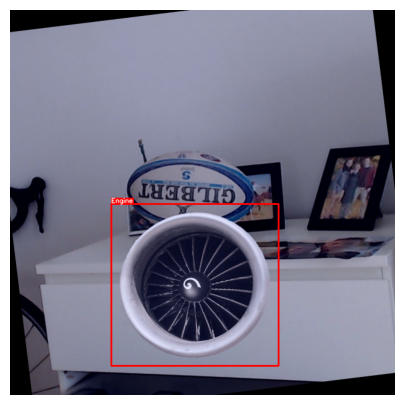

In [9]:
# Clear previous preprocessing output
os.chdir(paths['scripts'])
import imageProcessing as imgprep
os.chdir(paths['home'])

imgprep.clearPreprocessing(paths['images'])
imgprep.clearTraining(paths['training']+'/images')

numImgs = 250
upperScale = 350
lowerScale = 150

# Modify and multiply images and store in 1_Preprocessing folder
imgprep.main(dict_labels, paths['backgrounds'], paths['objects'], numImgs, upperScale, lowerScale, paths['images']+'/', paths['training']+'/')

imgprep.clearPreprocessing(paths['images'])

## 5.4 Create labelmap

In [10]:
# Convert label-dict to needed format
labelmap = []
for key in dict_labels:
  temp = {}
  temp['name'] = key
  temp['id'] = dict_labels[key]
  labelmap.append(temp)
print(labelmap)

with open(files['labelmap'], 'w') as file:
  for label in labelmap:
      file.write('item { \n')
      file.write('\tname:\'{}\'\n'.format(label['name']))
      file.write('\tid:{}\n'.format(label['id']))
      file.write('}\n')

[{'name': 'Engine', 'id': 1}]


## 5.5 Create TFRecord

In [11]:
# Create / overwrite TFRecord files for training and testing
subprocess.run(['python', files['generateTfRecord'], '-x', paths['images_training'], '-l', files['labelmap'], '-o', files['tf_train']])
subprocess.run(['python', files['generateTfRecord'], '-x', paths['images_testing'], '-l', files['labelmap'], '-o', files['tf_test']])

# Go back to home directory
os.chdir(paths['home'])

Successfully created the TFRecord file: /Volumes/Niklas/macOS/BachelorNB/projectTeleoperatedTaxibot/2_ObjectDetection/2_Tensorflow/workspace/training/annotations/train.record
Successfully created the TFRecord file: /Volumes/Niklas/macOS/BachelorNB/projectTeleoperatedTaxibot/2_ObjectDetection/2_Tensorflow/workspace/training/annotations/test.record


## 5.6 Download pre-trained model



In [15]:
# Check if the chosen model has already been downloaded
custom_model_name = userSettings['pretrainedModelName']
if os.path.exists(paths['pre_trained_models']+'/'+str(pre_trained_model_name)) is False:

  # Go to destination directory
  os.chdir(paths['pre_trained_models'])
  wget.download(pre_trained_model_url)

  # Extract all content of downloaded file
  import tarfile

  file = tarfile.open('ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz')

  file.extractall(paths['pre_trained_models'])

  file.close()

  # Create new folder for this model in training/models
  paths['active_model'] = paths['models']+'/'+custom_model_name
  os.makedirs(paths['active_model'])

  print('Model was successfully downloaded...')


else:
    print(str(pre_trained_model_name)+' was already installed...')

os.chdir(paths['home'])

  5% [...                                                                     ]  1130496 / 20518283

 12% [.........                                                               ]  2596864 / 20518283

 19% [..............                                                          ]  4063232 / 20518283

 27% [...................                                                     ]  5545984 / 20518283

 34% [........................                                                ]  7036928 / 20518283

 41% [.............................                                           ]  8511488 / 20518283

 48% [...................................                                     ]  9977856 / 20518283

 55% [........................................                                ] 11452416 / 20518283

 63% [.............................................                           ] 12926976 / 20518283

 70% [..................................................                      ] 14401536 / 20518283

 77% [.......................................................                 ] 15876096 / 20518283

 84% [............................................................            ] 17342464 / 20518283

 91% [..................................................................      ] 18817024 / 20518283

 98% [....................................................................... ] 20291584 / 20518283

100% [........................................................................] 20518283 / 20518283Model was successfully downloaded...


## 5.7 Update the config file and pipeline for the new training job

In [16]:
## Copy or replace pipeline in active model directory
files['pipeline_downloaded'] = paths['pre_trained_models']+'/'+pre_trained_model_name+'/pipeline.config'
paths['active_model'] = paths['models']+'/'+custom_model_name
files['pipeline_active'] = paths['active_model']+'/pipeline.config'
paths['downloaded_model'] = paths['pre_trained_models']+'/'+pre_trained_model_name

# If pipeline already exists in active directory, replace it
if os.path.exists(files['pipeline_active']) == True:
  os.remove(files['pipeline_active'])
  shutil.copy(files['pipeline_downloaded'], paths['active_model'])
  print('Pipeline replaced in active model directory...')

# If pipeline does not yet exist in active directory, copy it from downloaded model
else:
  files['pipeline_downloaded'] = paths['pre_trained_models']+'/'+pre_trained_model_name+'/pipeline.config' 
  shutil.copy(files['pipeline_downloaded'], paths['active_model'])
  print('Pipeline copied to active model directory...')

  ## Configure pipeline

  config = config_util.get_configs_from_pipeline_file(files['pipeline_active'])
  pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
  with tf.io.gfile.GFile(files['pipeline_active'], "r") as f:                                                                                                                                                                                                                     
      proto_str = f.read()                                                                                                                                                                                                                                          
      text_format.Merge(proto_str, pipeline_config)  


  pipeline_config.model.ssd.num_classes = len(labels) # Number of labels the model should be trained for
  pipeline_config.train_config.batch_size = 4 # This should be the number of training jobs that run parallel

  # Get checkpoint 0 from (original) downloaded model 
  files['checkpoint0'] = paths['downloaded_model']+'/checkpoint/ckpt-0'

  pipeline_config.train_config.fine_tune_checkpoint = files['checkpoint0']

  pipeline_config.train_config.fine_tune_checkpoint_type = "detection"

  # Get labelmap
  pipeline_config.train_input_reader.label_map_path= files['labelmap']

  # Get TF-Record
  pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [files['tf_train']]
  pipeline_config.eval_input_reader[0].label_map_path = files['labelmap']
  pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [files['tf_test']]

  config_text = text_format.MessageToString(pipeline_config)

  # Update active pipeline
  with tf.io.gfile.GFile(files['pipeline_active'], "wb") as f:                                                                                                                                                                                                                     
      f.write(config_text)   
      
  print('Pipeline successfully configured...')  

  # Copy model_main_tf2.py to workspace -> training   'TensorFlow/models/research/'
  source = paths['research']+'/object_detection/model_main_tf2.py'
  destination = paths['training']
  shutil.copy(source, destination)


Pipeline copied to active model directory...
Pipeline successfully configured...


# 6. Start new training job

In [28]:
files['training_script'] = paths['training']+'/model_main_tf2.py'
subprocess.run(['python',files['training_script'], '--model_dir='+paths['active_model'], '--pipeline_config_path='+files['pipeline_active'], '--num_train_steps=10000'])

Skipping step


# 7 Evaluate training

In [2]:
paths['train'] = paths['3_Output']+'/'+custom_model_name+'/train'
paths['eval'] = paths['3_Output']+'/'+custom_model_name+'/eval'

os.chdir(paths['eval'])
!tensorboard --logdir=.


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# 8 Move model to output folder

In [ ]:
# Copy labelmap to model folder
shutil.copy(files['labelmap'], paths['active_model'])

# Move active file directory to output folder
from distutils.dir_util import copy_tree
copy_tree(paths['active_model'], paths['3_Output']+'/'+custom_model_name)

# Delete model directory from models folder
shutil.rmtree(paths['active_model'])
print('Copied model to 3_Output and removed model directory from 2_Tensorflow')